In [7]:
#adapted from embarassingly paralell MCMC using Pool here:
# https://linuxtut.com/en/02d66723d03d7f977bb8/


from mcmc import *
from utilities import *
import matplotlib
import signal
from multiprocessing import Process, TimeoutError
from classy import Class
from mcmc import *



#instructions for user-defined exceptions from here https://www.programiz.com/python-programming/user-defined-exception
class Error(Exception):
	"""Base class for other exceptions"""
	pass

class ParamValueError(Error):
	"""Raised when strange parameter values prevent AxiCLASS from convering in reasonable time"""
	pass




#borrowed from https://stackoverflow.com/questions/492519/timeout-on-a-function-call
def handler(signum, frame):
	raise ParamValueError

def run_loop(pars):
	model_pars = pars['model_pars']
	l_min = pars['l_min']
	l_max = pars['l_max']

	
	for i in range(10):

		signal.signal(signal.SIGALRM, handler)
		signal.alarm(20)
		try:
			new_pars = model_pars
			new_pars['log10_axion_ac'] = np.random.normal(float(model_pars['log10_axion_ac']), abs(float(model_pars['log10_axion_ac'])*0.2))
			ls, Cls, Dls = get_power(new_pars, l_min, l_max)
		except ParamValueError:
			print('This step took too long! Skipping to next entry.')

In [8]:
import numpy as np
import numpy.random as rd
import scipy.stats as st
import copy, time, os
from datetime import datetime as dt

from multiprocessing import Pool, freeze_support

%matplotlib inline
import matplotlib.pyplot as plt

import functools

from p_tqdm import p_map

In [9]:
l_min = 90
l_max = 2000
num_steps = 100
num_chains = 10
num_burn_in = 0
saveFile = True
fileName = 'Sept-29_runs.txt'
runFromFile = False
inFileName = 'Sept-21_runs.txt'


n_axion = 3

model_pars = read_ini_file('example_axiCLASS.ini', loc='/Users/saravannah/Axion-MCMC/axion_MCMC/')
model_pars['n_axion'] = n_axion

params = {'num_burn_in': num_burn_in, 
          'l_min':  l_min, 'l_max': l_max, 'model_pars':model_pars }

In [10]:
#get parameters to start chains from

if runFromFile:
    #get full params from file
    par0, par1, par2, par3, par4 = np.loadtxt(inFileName, unpack = True)
    #find location of best Djs and start there
    idx = np.argmin(par4)

    log10_axion_ac_IN = par0[idx]
    log10_fraction_axion_ac_IN = par1[idx]
    omega_cdm_IN = par2[idx]
    H0_IN = par3[idx]
else:
    log10_axion_ac_IN = float(params['model_pars']['log10_axion_ac'])
    log10_fraction_axion_ac_IN = float(params['model_pars']['log10_fraction_axion_ac'])
    omega_cdm_IN = float(params['model_pars']['omega_cdm'])
    H0_IN = float(params['model_pars']['H0'])



In [13]:
import mcmc
%timeit mcmc.mcmc(num_burn_in, l_min, l_max, n_axion, log10_axion_ac_IN, log10_fraction_axion_ac_IN, omega_cdm_IN, H0_IN, 50)

Chain # 15181: 100%|██████████| 50/50 [14:15<00:00, 17.12s/it]

11min 56s ± 1min 31s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
######THIS CELL RUNS THE MCMC##########

freeze_support()

print('Making ', num_steps, ' samples per chain for ',  num_chains, ' chains. Burn-in rate: ', num_burn_in/num_steps)
pool = Pool(processes=num_chains)
n_trials_per_process = [num_steps] * num_chains
start = time.time()
total_sampling_result = pool.map(functools.partial(mcmc, num_burn_in, l_min, l_max, n_axion, log10_axion_ac_IN, log10_fraction_axion_ac_IN, omega_cdm_IN, H0_IN), n_trials_per_process)
end = time.time()
pool.close()
print('total exec time: ', end-start)

Making  100  samples per chain for  10  chains. Burn-in rate:  0.0


In [7]:
print(len(total_sampling_result))

10


In [19]:
log10_axion_ac = np.zeros((num_chains, len(total_sampling_result[0])))
log10_fraction_axion_ac = np.zeros((num_chains, len(total_sampling_result[0])))
omega_cdm = np.zeros((num_chains, len(total_sampling_result[0])))
H0 = np.zeros((num_chains, len(total_sampling_result[0])))
Djs = np.zeros((num_chains, len(total_sampling_result[0])))

for i in range(num_chains):
    log10_axion_ac[i] = [col[0] for col in total_sampling_result[i]] #extract column
    log10_fraction_axion_ac[i] = [col[1] for col in total_sampling_result[i]]
    omega_cdm[i] = [col[2] for col in total_sampling_result[i]]
    H0[i] = [col[3] for col in total_sampling_result[i]]
    Djs[i] = [col[4] for col in total_sampling_result[i]]


#chain0, chain1, chain2, chain3, chain4, chain5, chain6, chain7, chain8, chain9 = total_sampling_result[0], total_sampling_result[1], total_sampling_result[2], total_sampling_result[3], total_sampling_result[4], total_sampling_result[5], total_sampling_result[6], total_sampling_result[7], total_sampling_result[8], total_sampling_result[9]

In [20]:
saveFile = True

if saveFile:
    #create total array to combine all the chain data
    big_arr = np.zeros((5, len(log10_axion_ac[0])*num_chains))

    big_arr[0] = np.concatenate(([log10_axion_ac[i] for i in range(num_chains)]))
    big_arr[1] = np.concatenate(([log10_fraction_axion_ac[i] for i in range(num_chains)]))
    big_arr[2] = np.concatenate(([omega_cdm[i] for i in range(num_chains)]))
    big_arr[3] = np.concatenate(([H0[i] for i in range(num_chains)]))
    big_arr[4] = np.concatenate(([Djs[i] for i in range(num_chains)]))
    #save run to file
    with open(fileName, 'a') as fileObject:
        np.savetxt(fileObject, np.transpose(big_arr))   

In [21]:
#start_serial = time.time()
#serial_mcmc_results = mcmc(num_burn_in, l_min, l_max, n_axion, log10_axion_ac,
#                            log10_fraction_axion_ac, omega_cdm, H0, num_steps)
#end_serial = time.time()
#print('total exec time: ', end_serial-start_serial)

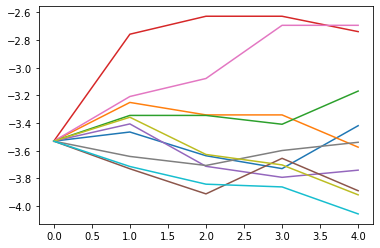

In [22]:
steps = np.arange(0,len(total_sampling_result[0]))
for i in range(num_chains):
    plt.plot(steps, log10_axion_ac[i])

In [12]:
model_pars = read_ini_file('example_axiCLASS.ini', loc='/Users/saravannah/Axion-MCMC/axion_MCMC/')

print(abs(float(model_pars['H0'])*0.1))

7.281000000000001
